## Import libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns

## Download and Preprocess Dataset

In [2]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

num_classes = 10

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



## Preprocessing

In [3]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 256 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

## Prepare the data

In [4]:
# function for adding some more data from other classes
def put_extra_data(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    for i in range(num_classes):
        if class_num != i:
            # get the indices where label == i
            temp_indices = np.asarray(np.where(source_dataset_labels == i))
            temp_indices = temp_indices.flatten()
            temp_indices = temp_indices[0:10]
            extra_images = source_dataset_images[temp_indices] # get some more negative images
            target_dataset = np.concatenate((target_dataset,extra_images))
    
    return target_dataset

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = np.full(shape=(dataset_images_positive.shape[0],2),fill_value=[1,0],dtype=np.float32)
    print(dataset_images_positive.shape)
    # get the images for making negative dataset
    dataset_images_negative = invert(dataset_images_positive) # inverted images
    # dataset_images_negative = np.empty((0,28,28),dtype=np.float32)
    dataset_images_negative = put_extra_data(dataset_images,dataset_labels,dataset_images_negative,class_num)
    print(dataset_images_negative.shape)

    # negative_data_indices = [i for i in range(len(dataset_labels)) if i not in indices]
    # dataset_images_negative = dataset_images[negative_data_indices]
    
    dataset_labels_negative = np.full(shape=(dataset_images_negative.shape[0],2),fill_value=[0,1],dtype=np.float32)
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

def concat_datasets(dataset1_images,dataset1_labels,dataset2_images,dataset2_labels,class_num):
    # join the two datasets
    joined_dataset_images = np.concatenate((dataset1_images,dataset2_images))
    joined_dataset_labels = np.concatenate((dataset1_labels,dataset2_labels))
    
    indices = np.asarray(np.where(joined_dataset_labels == class_num)) # indices of occurrence of class as label
    indices = indices.flatten()
    dataset_images_positive = joined_dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = np.full(shape=(dataset_images_positive.shape[0],2),fill_value=[1,0],dtype=np.float32)
    negative_data_indices = [i for i in range(len(joined_dataset_labels)) if i not in indices]
    
    dataset_images_negative = joined_dataset_images[negative_data_indices]
    dataset_labels_negative = np.full(shape=(dataset_images_negative.shape[0],2),fill_value=[0,1],dtype=np.float32) 
    
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

### Plotting some data

(5918, 28, 28)
(6008, 28, 28)


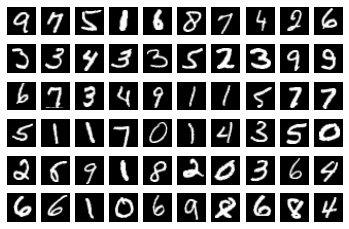

In [5]:
class_num = 6
train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=64,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=64,shuffle=True) # take original testing set of all classes
dataiter = iter(test_loader)
images,labels = dataiter.next()
figure = plt.figure()
# print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [6]:
# Model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,100),
            nn.ReLU(),
            nn.Linear(100,10),
            nn.ReLU(),
            nn.Linear(10,2),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

epochs = 30
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)

# function to train the model
loss_vals = []
model.train()
for e in range(epochs):
  epoch_loss = []
  for batch, (images,logits) in enumerate(train_loader):
    optimizer.zero_grad()
    # compute prediction error
    output = model(images)
    loss = criterion(output,logits)

    # Backpropagation
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())

# function to test the model
def test(dataloader,model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pred = []
    with torch.no_grad():
        for images,logits in dataloader:
            output = model(images)
            correct += (output.argmax(1) == logits.argmax(1)).type(torch.float).sum().item()
            for i in range(len(output)):
                pred.append(np.argmax(output.numpy()[i]))
    correct /= size
    print(f"Accuracy : {(100*correct):>0.1f}%")
    return pred
  


## Testing

In [14]:
# for class_num in range(num_classes):
#     train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
#     test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
#     train_loader = DataLoader(train_class_set,batch_size=64,shuffle=True)
#     test_loader = DataLoader(test_class_set,batch_size=64,shuffle=True) # take original testing set of all classes
    
#     model = NeuralNetwork()

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(),lr = 1e-3,momentum=0.9)
#     print(f"Class Number: {class_num}")
#     train(train_loader,model,criterion,optimizer)
#     y_pred_train = test(train_loader,model)
#     y_pred_test = test(test_loader,model)
# lb = LabelBinarizer()
# lb.fit([0,1])
# binarized_labels = lb.transform(y_pred_test)
# binarized_labels = np.hstack((binarized_labels,1-binarized_labels))
# print(binarized_labels)

scores = np.empty((0,3),dtype=np.float32)
test(test_loader,model)

with torch.no_grad():
    for images,logits in test_loader:
      output = model(images)
      output = output.numpy()
      logits = logits.numpy()
      for i in range(len(output)):
        yes_score = output[i][0]
        no_score = output[i][1]
        true_label =  1 if np.argmax(logits[i]) == 0 else 0 
        # if true_label == 1:
        scores = np.vstack((scores,[[yes_score,no_score,true_label]]))
print(scores)

df = pd.DataFrame(scores)
df.columns = ['yes_score','no_score','true_label']
df['yes_score'] = -np.log(df['yes_score'] + 0.001)
df['no_score'] = -np.log(df['no_score'] + 0.001)

Accuracy : 9.8%
[[9.99571741e-01 4.28211060e-04 0.00000000e+00]
 [9.99484181e-01 5.15794673e-04 0.00000000e+00]
 [9.99916077e-01 8.39700951e-05 1.00000000e+00]
 ...
 [9.99553263e-01 4.46771039e-04 0.00000000e+00]
 [9.95559692e-01 4.44028853e-03 0.00000000e+00]
 [9.92789447e-01 7.21051777e-03 0.00000000e+00]]


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


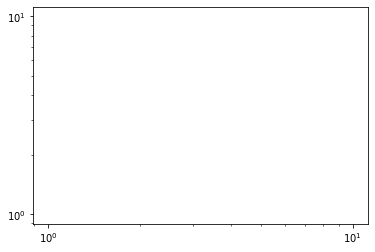

In [ ]:
# plt.loglog(scores[:,0],scores[:,1])

### Plotting the probability scores

          yes_score      no_score    true_label
count  70000.000000  70000.000000  70000.000000
mean       0.000893      6.143841      0.098229
std        0.003471      0.680481      0.297626
min       -0.000968      2.121310      0.000000
25%       -0.000782      5.734693      0.000000
50%       -0.000256      6.351475      0.000000
75%        0.001233      6.710572      0.000000
max        0.125421      6.876824      1.000000


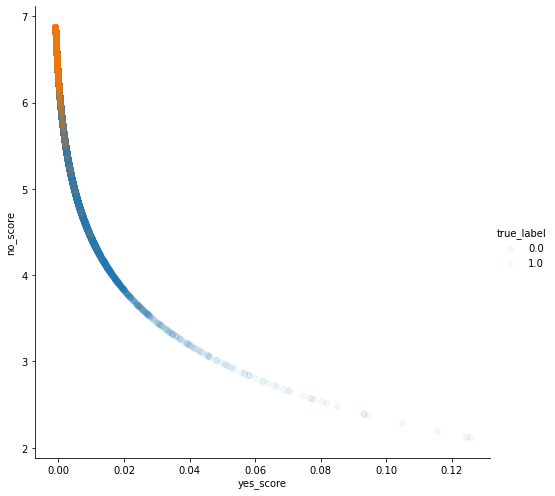

In [22]:

print(df.describe())
sns.FacetGrid(df,hue="true_label",height=7).map(plt.scatter,"yes_score","no_score",alpha=0.05).add_legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


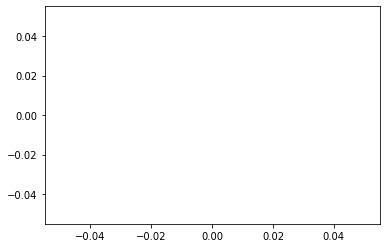

In [ ]:
plt.scatter(np.log(scores[:,0]),np.log(scores[:,1]))